# Tenny's Flight Path Data

in the 1968 edition of the *NFFS Symposium*, Bud Tenny published some interesting data on indoor flights. His data captured the flight path of a model in enough detail to be worthy of a deeper look. Specifically, he presented the model altitude, torque level, and prop rpm as a function of time. The only thing missing would have been an estimate of the flight speed during the flight. Considering how hard it was to gather this kind of data, we will work with it.

## Capturing raw data

NFFS has made PDF files with all past Symposium publications up to about 2010 available to members from their technical library. I loaded up Tenny's article on my laptop, zoomed his graphs up as large as I could, then used *SnagIt*, a screen capture program, to capture each graph as an image. Using *WebPlotAnalyzer* I digitized each curve and exported the data to a simple comma separated data file. Loading the raw data for processing using Python is then pretty simple.

### Step 1: Find the data

In [88]:
from pathlib import Path
from IPython.display import Image

This first bit of code let's me locate the directory holding my Jupyter page ( the one you are reading) on my computer. 

In [89]:
from pathlib import Path  # this makes manipulating system path names easy
cwd = !pwd                # where is this page
book_path = Path(cwd[0])  # this is the full path to this location

Now, I can locate the data directory holding all my digitized data.

In [90]:
datadir = book_path / '..' / '..' / 'mmtime' / 'data' # data folder for this project
torque_image = datadir / 'torque-curve.png'

### Step2: Display the raw image

Displaying an image in a Jupyter page is simple:

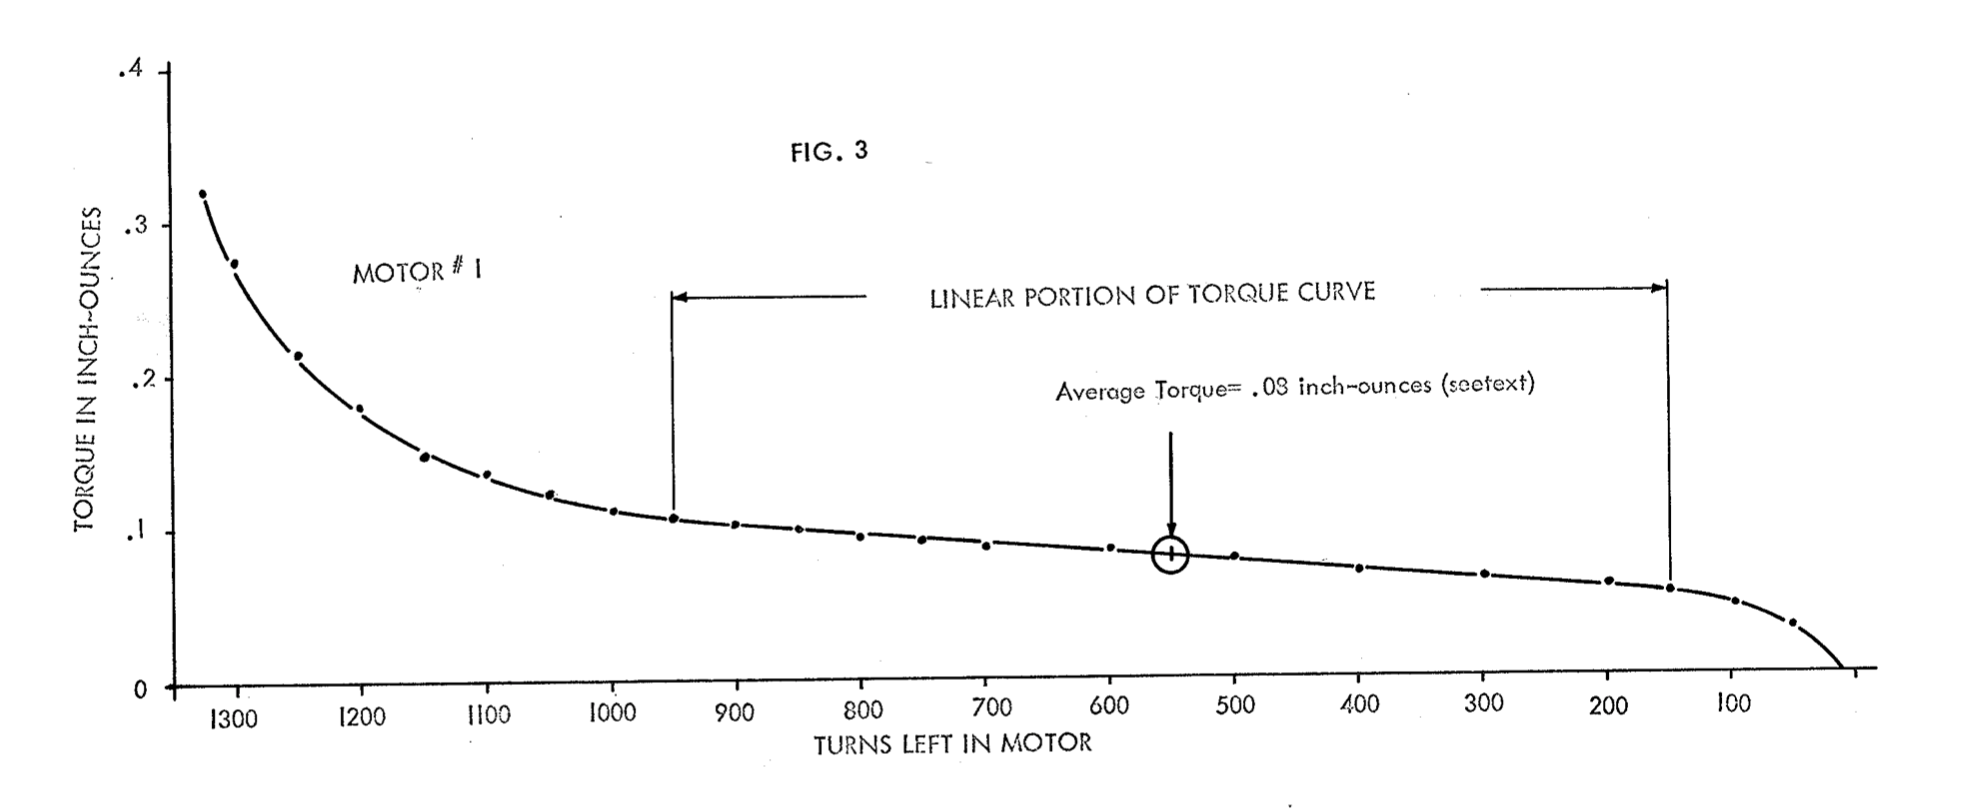

In [91]:
from IPython.display import Image
Image(filename=torque_image)

This is the image I digitized using *WebPlotDigitizer*.

###  Step3: Load the CSV Data

This step involves reading the *WebPlotDigitizer* data file and returning the data a usable Python form. Since we will be doing a lot of this, we will wrap up all the code in a function we can use as needed: 

In [92]:
import csv
import numpy as np

def get_points(filename):
    q_pts = []
    with open(filename,'r') as fin:
        raw_data = csv.reader(fin, delimiter=',')
        for row in raw_data:
            q_pts.append(row)
    x = []
    y = []
    for pt in q_pts:
        x.append(float(pt[0]))
        y.append(float(pt[1]))
    nx = np.array(x)
    ny = np.array(y)
    return nx,ny

**numpy** is a Python package that provides many useful tools for manipulating sets of data points. 

The **get_points** function returns two **numpy** arrays. Notice that we generate the **x** and ** y** values in separate arrays. 

Another useful package is **matplotlib** which can generate nice plots for us. Staring a lists of numbers is not fun! Seeing those numbers on a nice plot makes the data far easier to understand! 

Here is a utility routine to simplify generating plots:

In [93]:
import matplotlib.pyplot as plt

def show_curve(x,y,title,xlabel,ylabel):
    plt.plot(x,y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

### Step 4: Display Digitized Data

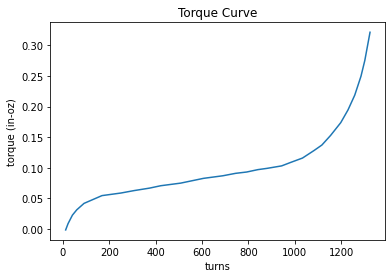

In [94]:
torque_csv = datadir / 'torque-curve.csv'
q_nx, q_ny = get_points(torque_csv)
show_curve(q_nx, q_ny, "Torque Curve", "turns", "torque (in-oz)")

**matplotlib** flipped this curve from the original, but it shows the same data.

We now have a process we can use to capture data from any source where we can get an image of a curve. Many research articles show figures with data curves, but space limitations preclude include tabulated data. This entire process is a big part of the new *Data Science* field that seeks to mine data from multiple sources and generate new useful information from that data! As you might expect, the Python tools we are demonstrating here are very popular in data science research!

## Propeller Speed Data

We can now look at the propeller speed data:

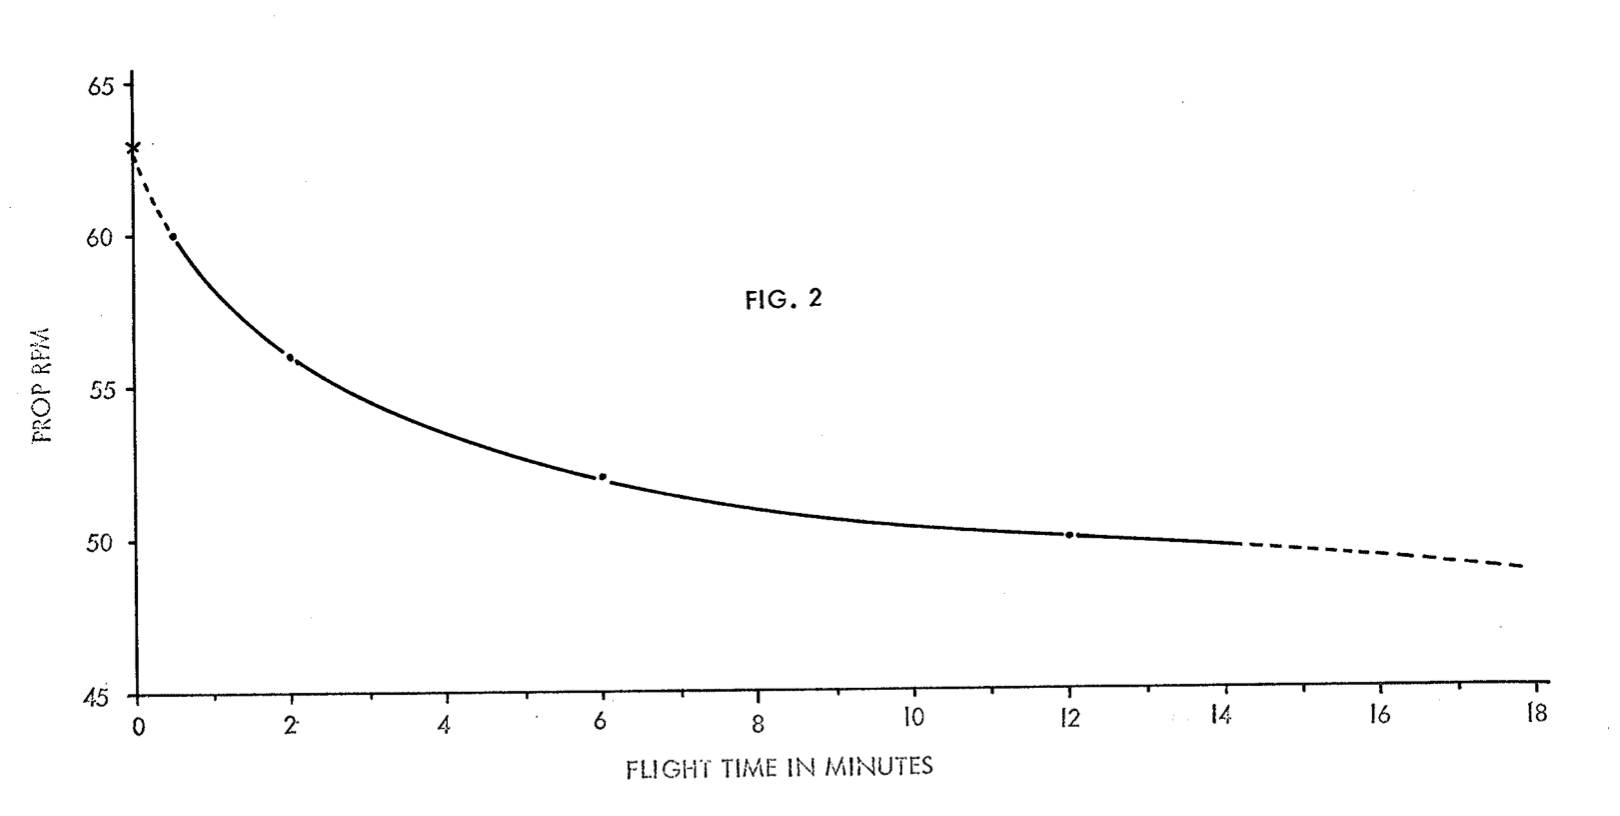

In [95]:
rpm_image = datadir / 'prop-rpm.png'
Image(filename=rpm_image)

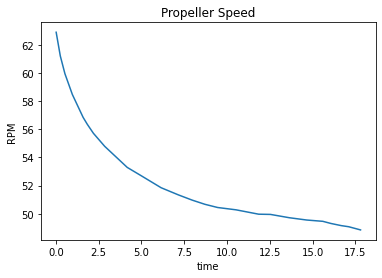

In [96]:
rpm_csv = datadir / 'prop-rpm.csv'
rpm_x, rpm_y = get_points(rpm_csv)
show_curve(rpm_x, rpm_y, "Propeller Speed", "time", "RPM")

## Flight Profile Data

Tenny recorded the height of the model as a function of time. This was a tedious process involving a balloon and multiple readers trying to gauge the height of the model and balloon then reading markings on the string holding the balloon! 

Here is Tenny's graph:

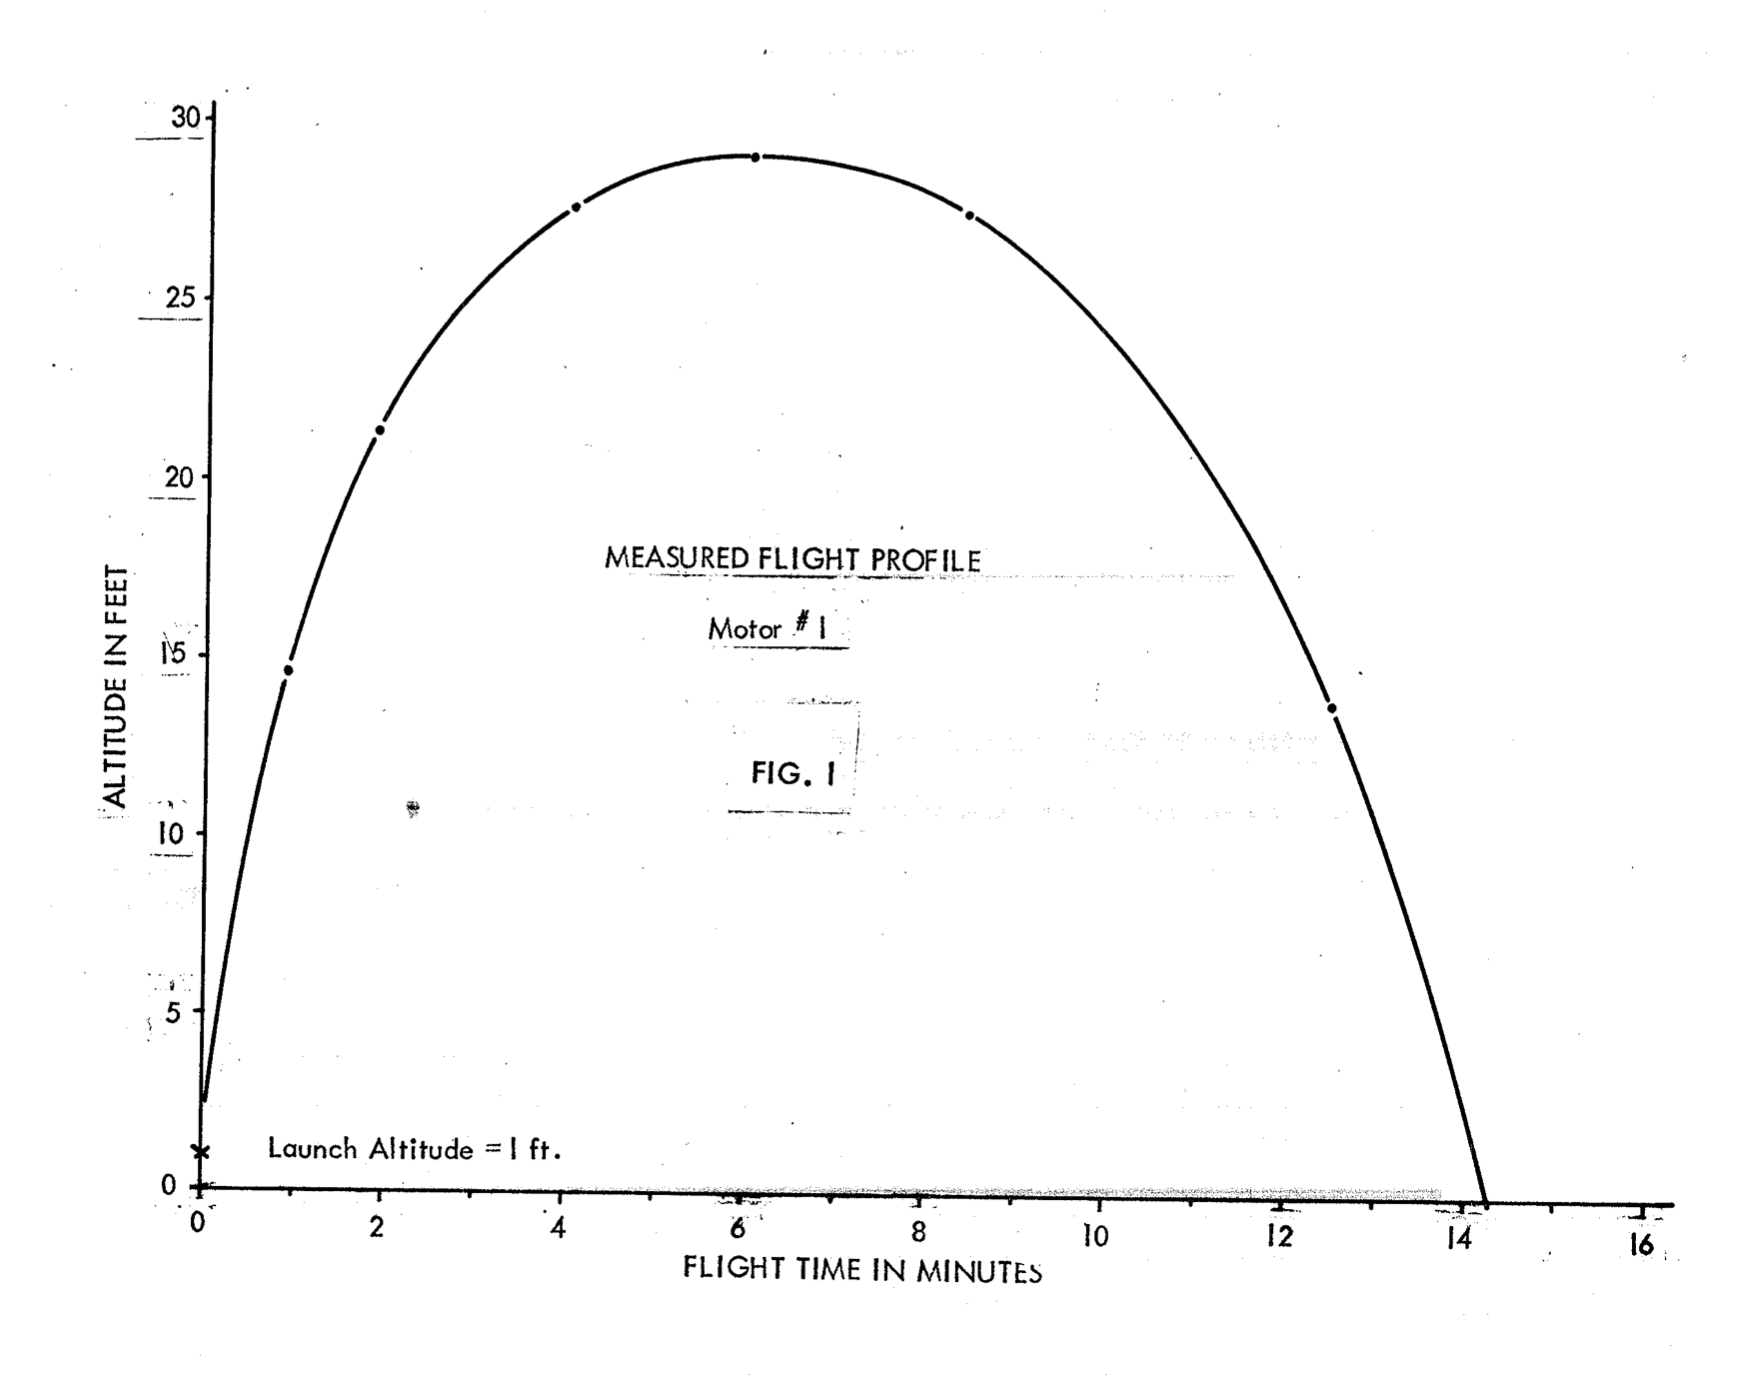

In [97]:
fp_image = datadir / 'flight-profile.png'
Image(filename=fp_image)

Here is our digitized result:

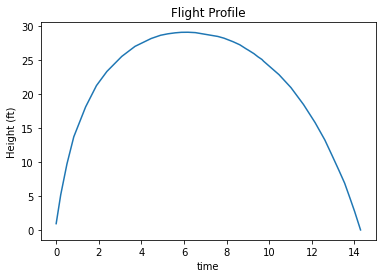

In [98]:
fp_csv = datadir / 'flight-profile.csv'
Image(filename=fp_image)
fp_x, fp_y = get_points(fp_csv)
show_curve(fp_x, fp_y, "Flight Profile", "time", "Height (ft)")

## Curve Fit Functions

We cannot do much with the data sets in their current form. We need to convert them into functions that can deliver a dependent value **y** for any independent value **x**. We can make that happen by using one of the curve fit routines in the Python **scipy** package. Here is a function that will accept our data point arrays and return a function we can use the generate results for any **x** value we like. You should be wary of asking for results outside of the original data range. The results might not be what you expect.

Here is a utility curve-fit function:

In [99]:
from scipy import interpolate

def fit_curve(x, y): # using a cubic spline
    fit = interpolate.CubicSpline(x,y)
    return fit

This function accepts two **numpy** arrays and returns a function that will return a value for any input **x** value. Internally, a standard cubic spline is generated that enables it to interpolate between data points. The function will work beyond the ends of the input data, but working there is not to be trusted. Extrapolation assumes something about how the function works in regions where we have no data!

In the next sections we will create data functions for our digitized data, and show how they work.

### Torque as a Function of Turns (q_n)


We have a minor problem with the torque curve. The raw data **x** axis shows turns remaining, which is a decreasing number. The curve fit routines need increasing values. To cure this, I am going to change the values to turns expended by subtracting the input data from the max turns on the plot. **numpy** makes this is easier than it sounds:

In [116]:
max_turns = q_nx[0]
q1_nx = max_turns - q_nx
q_n = fit_curve(q1_nx, q_ny)

To display this function at work, we need to create an array holding sample points for our **x** axis. Then we  have **numpy** apply our function to all points in the new sample set, returning a new array hoding our **y** values.

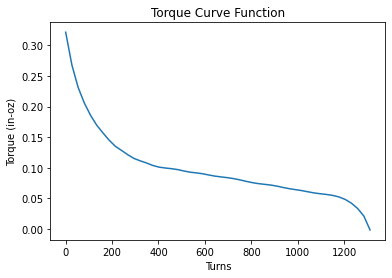

In [118]:
n_sample = np.linspace(q1_nx[0], q1_nx[-1], 50)
q_sample = q_n(n_sample)
show_curve(n_sample, q_sample, "Torque Curve Function", "Turns", "Torque (in-oz)")

### RPM as a Function of Time (n_t)

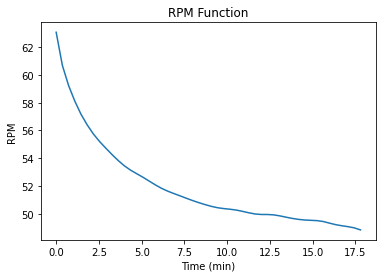

In [102]:
fn_t = fit_curve(rpm_x, rpm_y)
n_t = fn_t(time)

max_time = rpm_x[-1]
t_samples = np.linspace(0, max_time, 50)
rpm_samples = fn_t(t_samples)
show_curve(t_samples, rpm_samples, "RPM Function", "Time (min)", "RPM")

### Height as a Function of Time (h_t)

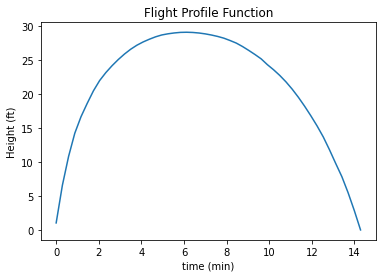

In [103]:
flight_time = fp_x[-1]  # last point on the flight profile time axis
fh_t = fit_curve(fp_x, fp_y)
t_samples = np.linspace(0,flight_time,50)
h_samples = fh_t(t_samples)
show_curve(t_samples, h_samples, "Flight Profile Function","time (min)", "Height (ft)")

At this point, we have a scheme to generate data curve functions we can use to do further analysis. Let's see examples of using this new capability to generate something new.

## Generate New Data

Once we have our functions available, we can generate new data.

### Vertical velocity

let's try to find the slope of the height curve, which gives us the vertical velocity of the vehicle over time. We start off by asking **scipy** to find the value of turns for an input torque. We are basically switching dependent and independent variables here:

In [104]:
launch_torque = 0.2
launch_turns = q_n.solve(y=launch_torque)
print(launch_turns)

[87.77567122]


Now, we take the derivative of the height function in a different **h_t** which gives us the vertical speed:

In [105]:
fdh_t = fh_t.derivative()
dhdt_pts = fdh_t(t_samples)

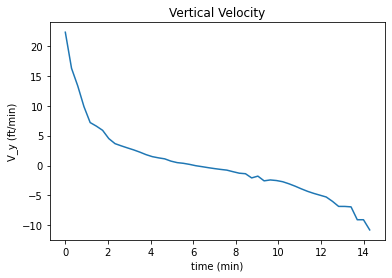

In [106]:
show_curve(time_pts,dhdt_pts,"Vertical Velocity","time (min)", "V_y (ft/min)")

Digitized data is often a bit lumpy. We see the effects of that in this curve. There are ways to smooth this kind of data, but doing so might introduce more errors. In this case, smoothing the original data might help.

Tenny included some tabulated data on vertical speed. Let's see how this curve compares with his data:

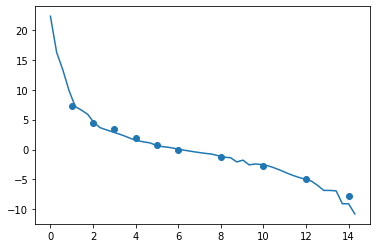

In [107]:
time_samples = np.array([1,2,3,4,5,6,8,10,12,14])
time_values = np.array([7.3,4.5,3.5,2.0,0.8,0,-1.2,-2.7,-5.0,-7.7])
fitted_dhdt = fdh_t(t_samples)
plt.plot(time, fitted_dhdt)
plt.scatter(time_samples, time_values)
plt.show()

This kind of result gives you confidence in your analytical tools.

### Propeller Power

Before we leave Tenny's data, let's do one more analysis.

The rate at which work is done by the propeller is defined as the *propeller power*, $P$:

\begin{equation}
P = 2\pi n Q
\end{equation}

where $n$ is the prop speed (rpm) and $Q$ is the torque. 

The torque data we have is torque/turns and we need torque/time. 

Let's review the functions we have generated:

- torque as a function of turns (q_n)

\begin{equation}\label{eq:torque}
q_n = Q(n)
\end{equation}

- RPM as a function of time (fn_t)

\begin{equation}\label{eq:rpm}
rpm_t = R(t)
\end{equation}

- turns as a function of time (n_t)

\begin{equation}\label{eq:turn_time}

\end{equation}

So, if we have a given time $t$ then

\begin{equation}\label{eq:torque_time}
q_t = Q(R(t))
\end{equation}

We have rpm data measured over time. If we integrate that function we will get a function for turns as a function of time. 

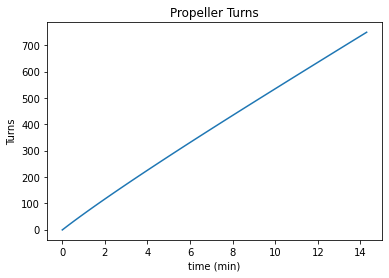

In [108]:
ft_t = fn_t.antiderivative() # inverse of derivative
turn_samples = ft_t(t_samples)
show_curve(t_samples, turn_samples, "Propeller Turns", "time (min)", "Turns")

The last point on this curve is the remaining turns after the airplane landed:

In [109]:
print("Flight turns =",turn_samples[-1])

Flight turns = 749.2462187922157


This curve may look straight, but it is not. The interesting thing that it shows is how many turns were used in this flight, 749 from that last number printed. According to Tenny's article, the motor was wound to  about 1240 turns (0.2 inch-oz of torque, and landed with about 500 turns remaining. This analysis said it would have landed with 1240-749 = 491 turns! Not bad!

We can now use these two functions to get our new torque/time function:

In [110]:
def fq_t(time):
    turns = ft_t(time)
    q = q_n(turns)
    return q

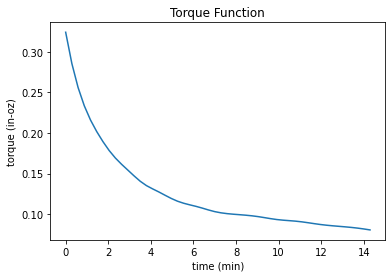

In [111]:
q_samples = fq_t(t_samples)
show_curve(t_samples, q_samples, "Torque Function", "time (min)","torque (in-oz)")

Now we can get our power curve:

In [112]:
import math

P_samples = 2 * math.pi * rpm_samples * q_samples

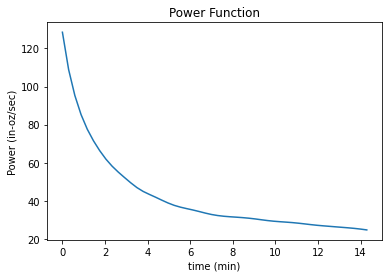

In [113]:
show_curve(t_samples, P_samples,"Power Function", "time (min)","Power (in-oz/sec)") 

You can see the power burst at launch. Interesting!

I think you can see how useful these techniques can be in conducting an analysis. The combination of *Jupyter* and Python lets you experiment with thing, and see results quickly. This speeds up your work significantly!

Walter Erbach, in a paper we will look at later, lamented that he had to analyze "terrifying yards of tabulated results" to conduct his research. Thankfully, those days are over!"